In [54]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [55]:
warnings.filterwarnings('ignore')

In [56]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:02<00:00, 3685.42it/s]


In [57]:
def flat_dataset(log):
    flat_data = log \
        .groupby(['case:case']) \
        .agg(
            germanSpeaking=('case:german speaking', 'first'),
            yearsOfEducation=('case:yearsOfEducation', 'first'),
            age=('case:age', 'first'),
            gender=('case:gender', 'first'),
            citizen=('case:citizen', 'first'),
            protected=('case:protected', 'first'),
            married=('case:married', 'first')
        )
    
    flat_data['ageGroup'] = pd.cut(
        flat_data['age'],
        bins=[0, 25, 50, 200],
        labels=['0-25', '25-50', '>50']
    )
    
    flat_data['screening'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Screen Prospective Tenant' in x.values)
    
    flat_data['extensiveScreening'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Extensive Screening' in x.values)
    
    flat_data['contract'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Sign Contract' in x.values)
    
    flat_data['denied'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Reject Prospective Tenant' in x.values)
    
    flat_data['missedPayments'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: x.str.contains('Miss Rent Payment').sum())
    
    flat_data['latePayments'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: x.str.contains('Accept Late Payment').sum())
    
    flat_data['evicted'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Evict Tenant' in x.values)
    
    flat_data['cancelled'] = log \
        .groupby(['case:case'])['concept:name'] \
        .transform(lambda x: 'Tenant Cancels Appartment' in x.values)
    
    flat_data['duration'] = log \
        .groupby(['case:case'])['time:timestamp'] \
        .transform(lambda x: (x.max() - x.min()).days)

    return flat_data

In [58]:
flat_low = flat_dataset(log_low)
flat_medium = flat_dataset(log_medium)
flat_high = flat_dataset(log_high)

In [59]:
flat_low

,germanSpeaking,yearsOfEducation,age,gender,citizen,protected,married,ageGroup,screening,extensiveScreening,contract,denied,missedPayments,latePayments,evicted,cancelled,duration
case:case,,,,,,,,,,,,,,,,,
1,False,8,25,False,False,False,True,0-25,True,False,True,False,0,0,False,True,9
2,False,7,53,False,False,False,False,>50,True,False,True,False,0,0,False,True,9
3,False,4,46,True,False,False,True,25-50,True,False,True,False,0,0,False,True,9
4,True,12,49,True,True,False,False,25-50,True,False,True,False,0,0,False,True,9
5,True,2,62,False,False,True,False,>50,True,False,True,False,0,0,False,True,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,False,1,59,True,True,True,True,>50,True,False,True,False,1,0,True,False,10
9997,True,6,59,True,True,False,False,>50,True,False,True,False,1,0,True,False,10
9998,False,12,40,True,True,False,True,25-50,True,False,True,False,1,0,True,False,10


## Acceptance / Denial

In [72]:
def print_acceptance_denial_counts(flat_data):
    for column in ['gender', 'ageGroup', 'germanSpeaking', 'married', 'citizen', 'yearsOfEducation']:
        print('-------------------------------------------------------')
        print('Column: ', column)

        distinct_values = flat_data[column].unique()

        for value in sorted(distinct_values):
            accepted_n = len(flat_data[(flat_data[column] == value) & (flat_data['contract'] == True)])
            denied_n = len(flat_data[(flat_data[column] == value) & (flat_data['denied'] == True)])
            total_n = len(flat_data[flat_data[column] == value])

            print("\tValue: ", value)
            print('\t- Accepted: ', accepted_n, '->', round(accepted_n / total_n, 5) * 100, '%' )
            print('\t- Denied: ', denied_n, '->', round(denied_n / total_n, 5) * 100, '%' )
            print()

        # plot bar chart
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.countplot(x=column, hue='contract', data=flat_data, ax=ax)
        plt.title(column)
        plt.show()

### Low dataset

-------------------------------------------------------
Column:  gender
	Value:  False
	- Accepted:  2523 -> 56.40500000000001 %
	- Denied:  1950 -> 43.595 %

	Value:  True
	- Accepted:  3197 -> 57.843 %
	- Denied:  2330 -> 42.157 %



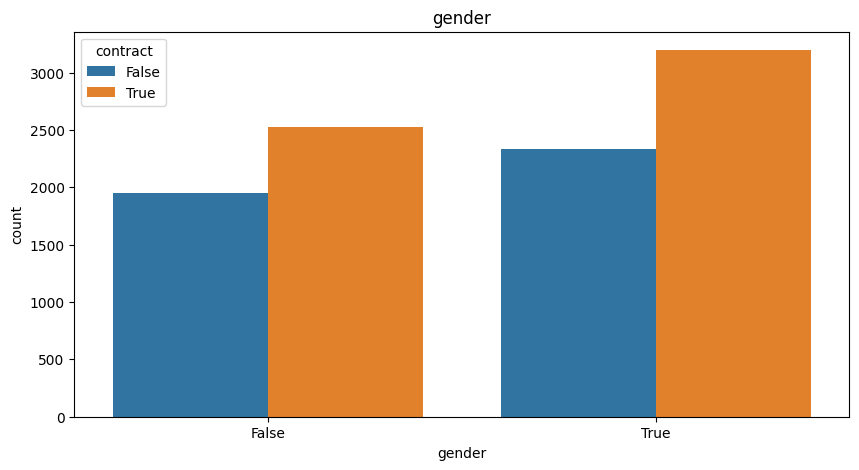

-------------------------------------------------------
Column:  ageGroup
	Value:  0-25
	- Accepted:  31 -> 64.583 %
	- Denied:  17 -> 35.417 %

	Value:  25-50
	- Accepted:  2631 -> 56.230000000000004 %
	- Denied:  2048 -> 43.769999999999996 %

	Value:  >50
	- Accepted:  3058 -> 57.994 %
	- Denied:  2215 -> 42.006 %



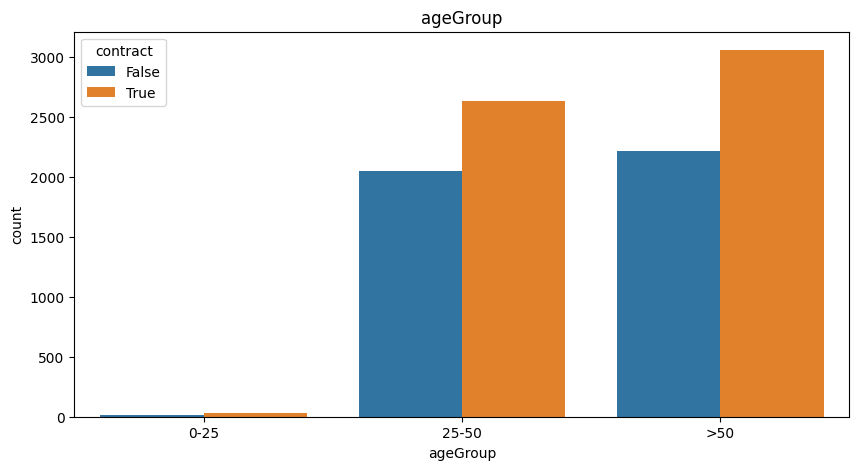

-------------------------------------------------------
Column:  germanSpeaking
	Value:  False
	- Accepted:  2550 -> 57.342000000000006 %
	- Denied:  1897 -> 42.658 %

	Value:  True
	- Accepted:  3170 -> 57.086000000000006 %
	- Denied:  2383 -> 42.914 %



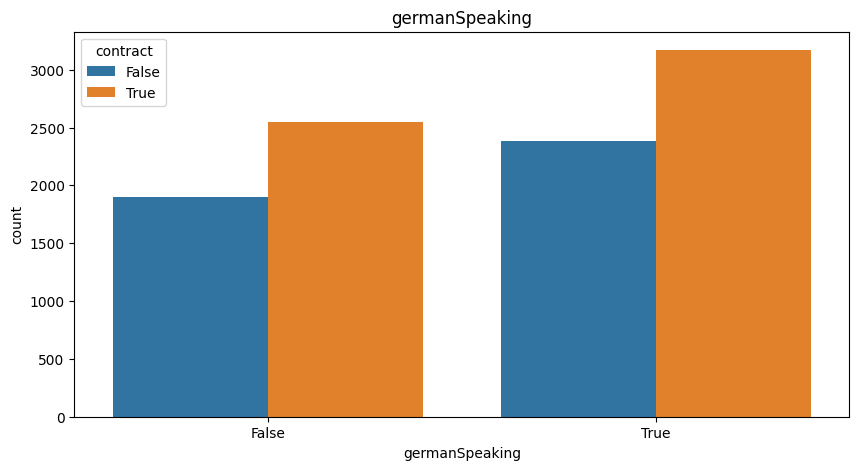

-------------------------------------------------------
Column:  married
	Value:  False
	- Accepted:  2523 -> 58.053 %
	- Denied:  1823 -> 41.947 %

	Value:  True
	- Accepted:  3197 -> 56.544000000000004 %
	- Denied:  2457 -> 43.456 %



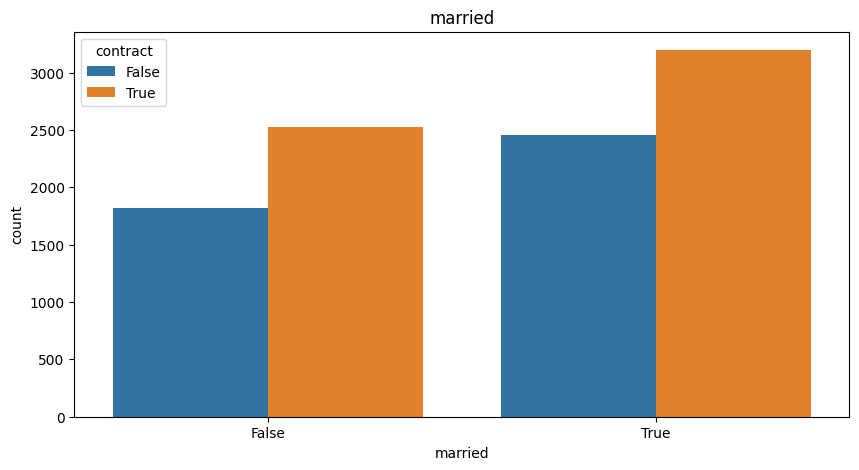

-------------------------------------------------------
Column:  citizen
	Value:  False
	- Accepted:  2527 -> 57.237 %
	- Denied:  1888 -> 42.763 %

	Value:  True
	- Accepted:  3193 -> 57.17100000000001 %
	- Denied:  2392 -> 42.829 %



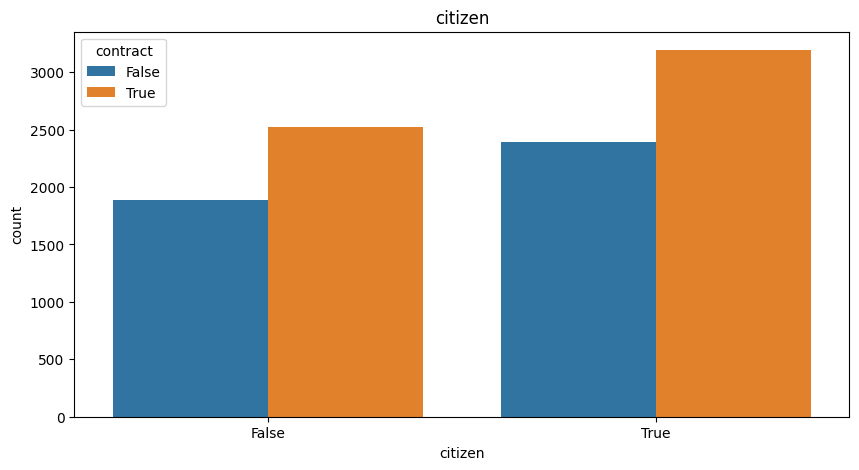

-------------------------------------------------------
Column:  yearsOfEducation
	Value:  1
	- Accepted:  174 -> 56.678 %
	- Denied:  133 -> 43.322 %

	Value:  2
	- Accepted:  115 -> 56.373 %
	- Denied:  89 -> 43.627 %

	Value:  3
	- Accepted:  196 -> 56.977 %
	- Denied:  148 -> 43.023 %

	Value:  4
	- Accepted:  270 -> 58.952000000000005 %
	- Denied:  188 -> 41.048 %

	Value:  5
	- Accepted:  340 -> 57.626999999999995 %
	- Denied:  250 -> 42.373 %

	Value:  6
	- Accepted:  456 -> 59.763999999999996 %
	- Denied:  307 -> 40.236 %

	Value:  7
	- Accepted:  497 -> 54.081 %
	- Denied:  422 -> 45.919 %

	Value:  8
	- Accepted:  615 -> 56.63 %
	- Denied:  471 -> 43.37 %

	Value:  9
	- Accepted:  669 -> 55.75 %
	- Denied:  531 -> 44.25 %

	Value:  10
	- Accepted:  678 -> 58.196999999999996 %
	- Denied:  487 -> 41.803000000000004 %

	Value:  11
	- Accepted:  604 -> 59.041999999999994 %
	- Denied:  419 -> 40.958 %

	Value:  12
	- Accepted:  436 -> 55.897 %
	- Denied:  344 -> 44.102999999999994

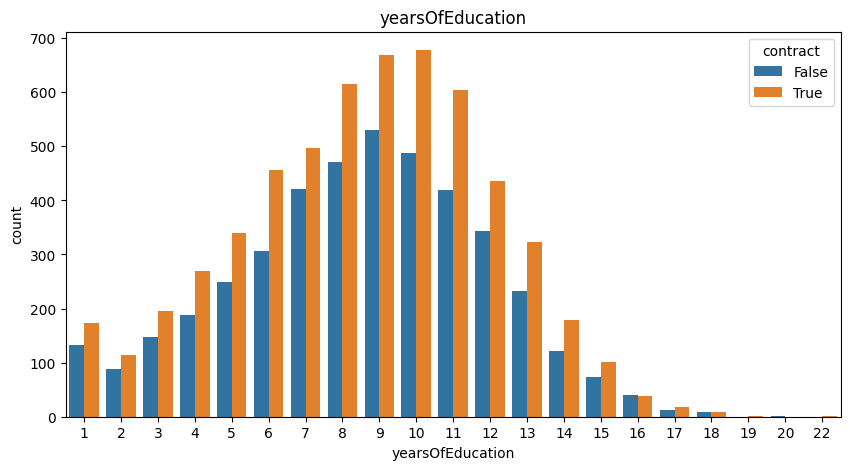

In [73]:
print_acceptance_denial_counts(flat_low)

### Medium dataset

-------------------------------------------------------
Column:  gender
	Value:  False
	- Accepted:  3370 -> 65.988 %
	- Denied:  1737 -> 34.012 %

	Value:  True
	- Accepted:  3209 -> 65.583 %
	- Denied:  1684 -> 34.416999999999994 %



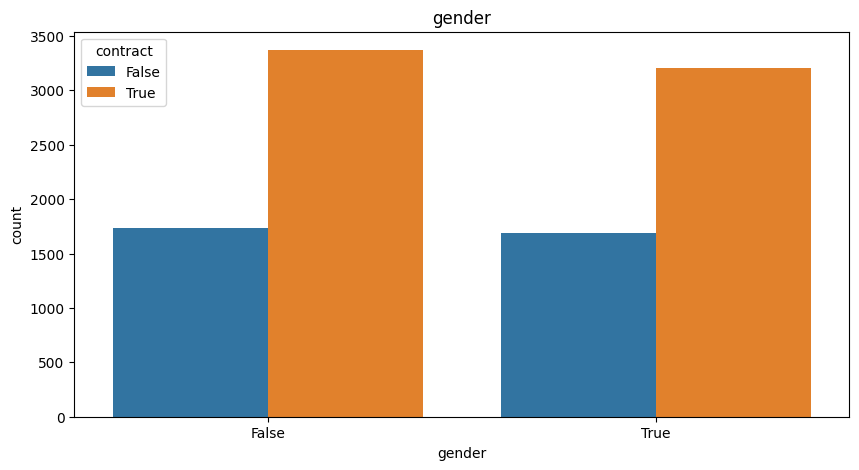

-------------------------------------------------------
Column:  ageGroup
	Value:  0-25
	- Accepted:  28 -> 54.901999999999994 %
	- Denied:  23 -> 45.098 %

	Value:  25-50
	- Accepted:  3237 -> 66.156 %
	- Denied:  1656 -> 33.844 %

	Value:  >50
	- Accepted:  3314 -> 65.546 %
	- Denied:  1742 -> 34.454 %



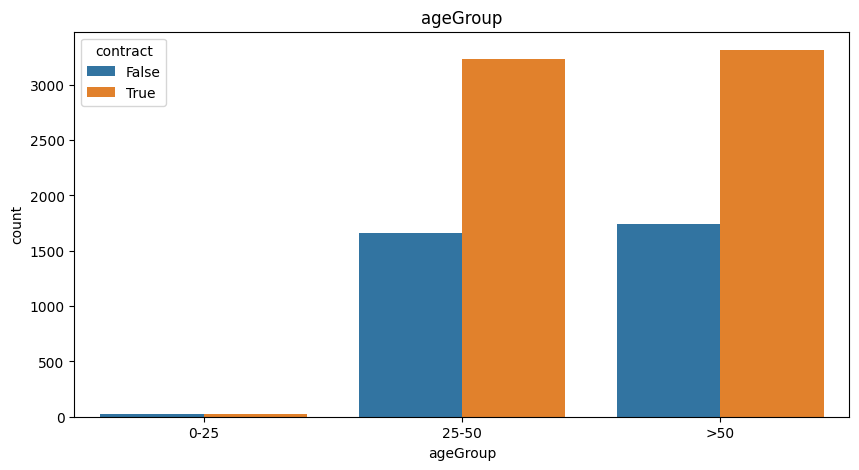

-------------------------------------------------------
Column:  germanSpeaking
	Value:  False
	- Accepted:  2303 -> 66.77300000000001 %
	- Denied:  1146 -> 33.227000000000004 %

	Value:  True
	- Accepted:  4276 -> 65.27199999999999 %
	- Denied:  2275 -> 34.727999999999994 %



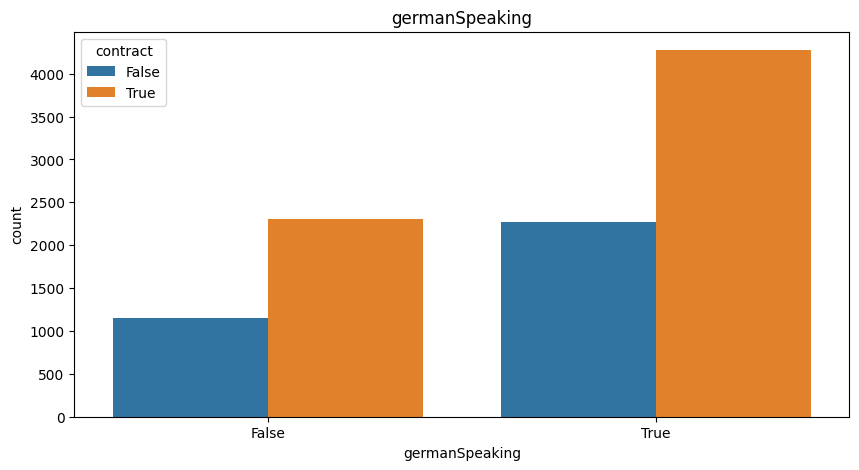

-------------------------------------------------------
Column:  married
	Value:  False
	- Accepted:  2217 -> 65.592 %
	- Denied:  1163 -> 34.408 %

	Value:  True
	- Accepted:  4362 -> 65.891 %
	- Denied:  2258 -> 34.109 %



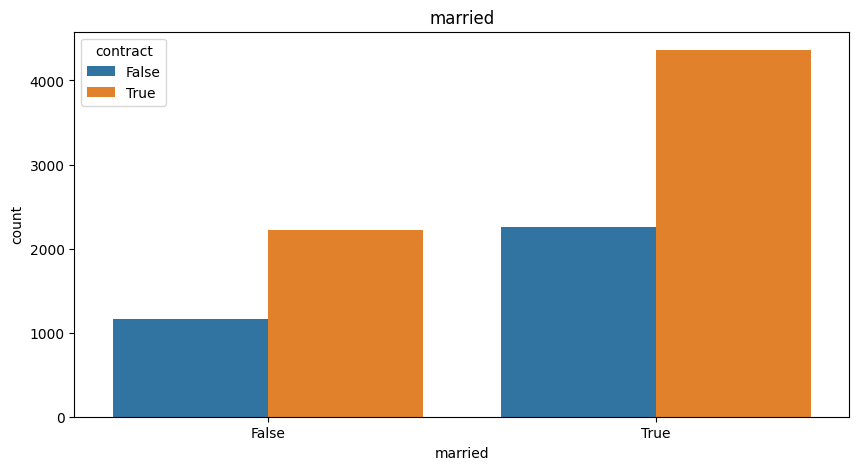

-------------------------------------------------------
Column:  citizen
	Value:  False
	- Accepted:  2194 -> 65.551 %
	- Denied:  1153 -> 34.449000000000005 %

	Value:  True
	- Accepted:  4385 -> 65.91 %
	- Denied:  2268 -> 34.089999999999996 %



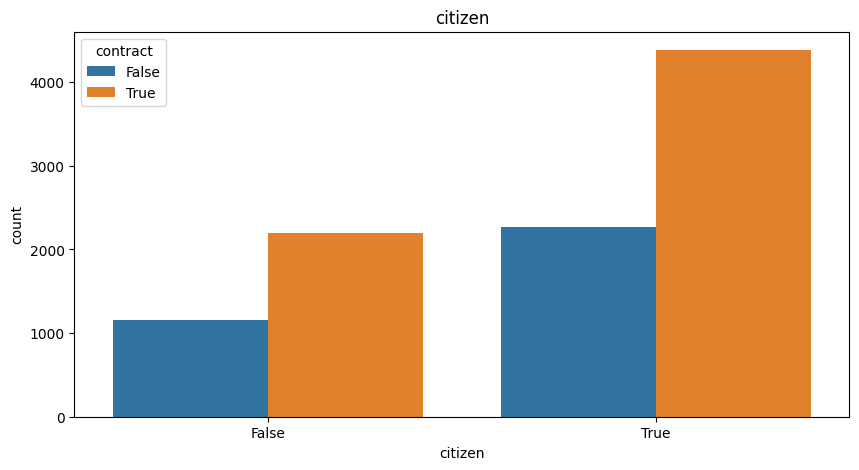

-------------------------------------------------------
Column:  yearsOfEducation
	Value:  1
	- Accepted:  502 -> 63.868 %
	- Denied:  284 -> 36.132 %

	Value:  2
	- Accepted:  75 -> 59.524 %
	- Denied:  51 -> 40.476 %

	Value:  3
	- Accepted:  119 -> 73.006 %
	- Denied:  44 -> 26.994 %

	Value:  4
	- Accepted:  160 -> 67.511 %
	- Denied:  77 -> 32.489000000000004 %

	Value:  5
	- Accepted:  245 -> 65.333 %
	- Denied:  130 -> 34.666999999999994 %

	Value:  6
	- Accepted:  384 -> 64.646 %
	- Denied:  210 -> 35.354 %

	Value:  7
	- Accepted:  522 -> 63.892 %
	- Denied:  295 -> 36.108000000000004 %

	Value:  8
	- Accepted:  718 -> 66.97800000000001 %
	- Denied:  354 -> 33.022 %

	Value:  9
	- Accepted:  848 -> 67.624 %
	- Denied:  406 -> 32.376 %

	Value:  10
	- Accepted:  819 -> 65.103 %
	- Denied:  439 -> 34.897 %

	Value:  11
	- Accepted:  752 -> 66.372 %
	- Denied:  381 -> 33.628 %

	Value:  12
	- Accepted:  561 -> 64.261 %
	- Denied:  312 -> 35.739 %

	Value:  13
	- Accepted:  407 ->

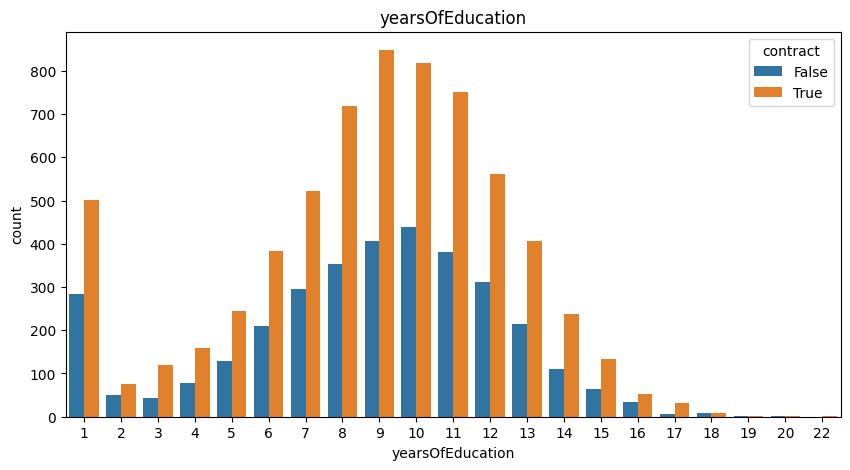

In [74]:
print_acceptance_denial_counts(flat_medium)

### High dataset

-------------------------------------------------------
Column:  gender
	Value:  False
	- Accepted:  2185 -> 51.888 %
	- Denied:  2026 -> 48.112 %

	Value:  True
	- Accepted:  3004 -> 51.892 %
	- Denied:  2785 -> 48.108000000000004 %



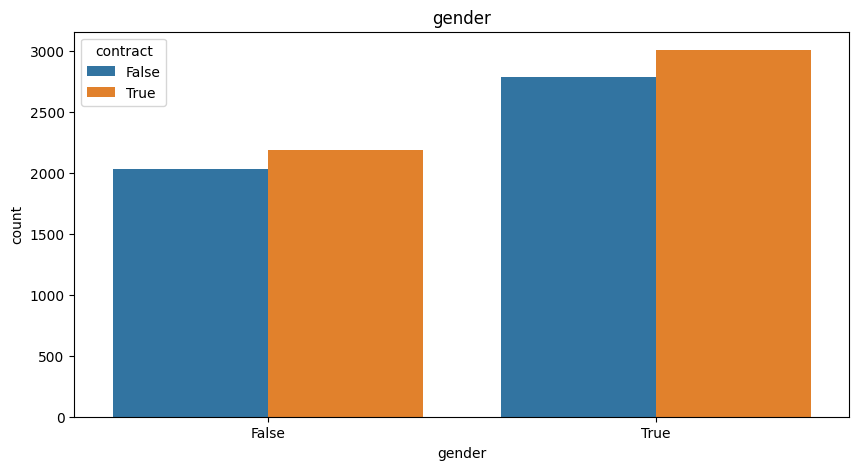

-------------------------------------------------------
Column:  ageGroup
	Value:  0-25
	- Accepted:  32 -> 56.14 %
	- Denied:  25 -> 43.86 %

	Value:  25-50
	- Accepted:  2827 -> 52.449 %
	- Denied:  2563 -> 47.551 %

	Value:  >50
	- Accepted:  2330 -> 51.175000000000004 %
	- Denied:  2223 -> 48.825 %



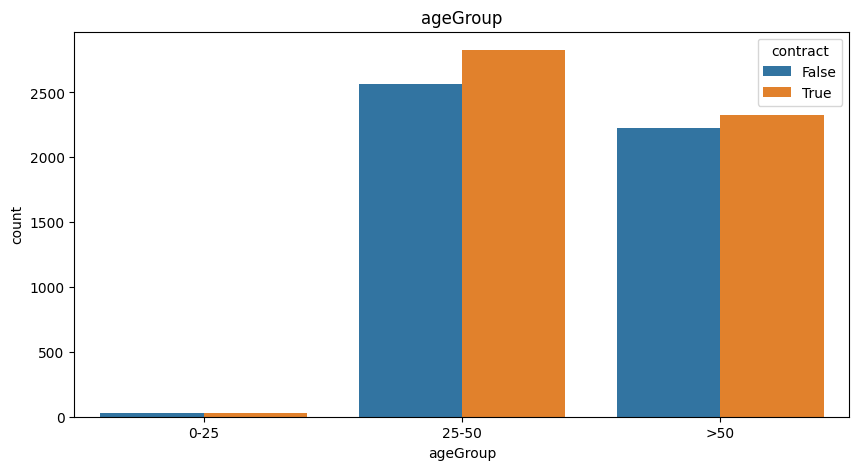

-------------------------------------------------------
Column:  germanSpeaking
	Value:  False
	- Accepted:  2665 -> 52.347 %
	- Denied:  2426 -> 47.653 %

	Value:  True
	- Accepted:  2524 -> 51.416 %
	- Denied:  2385 -> 48.583999999999996 %



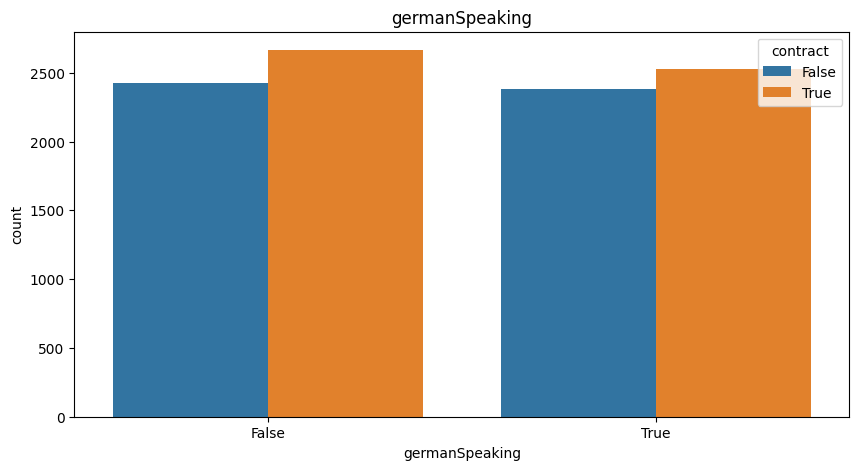

-------------------------------------------------------
Column:  married
	Value:  False
	- Accepted:  2559 -> 51.551 %
	- Denied:  2405 -> 48.449 %

	Value:  True
	- Accepted:  2630 -> 52.224000000000004 %
	- Denied:  2406 -> 47.776 %



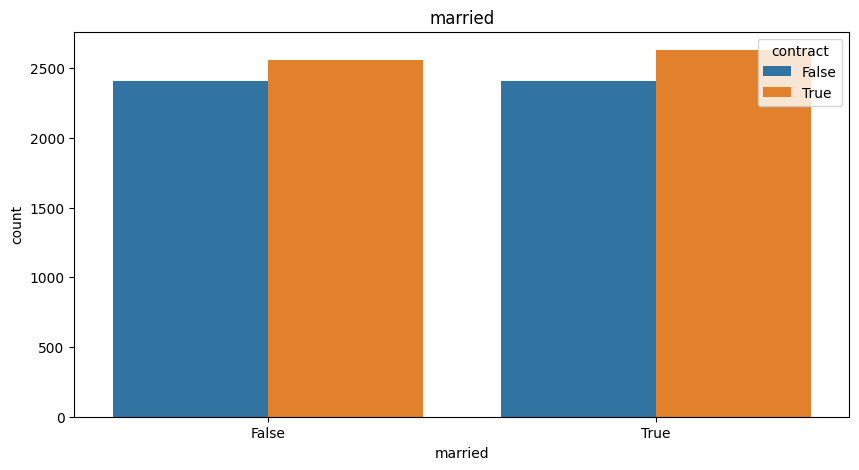

-------------------------------------------------------
Column:  citizen
	Value:  False
	- Accepted:  2580 -> 51.714000000000006 %
	- Denied:  2409 -> 48.286 %

	Value:  True
	- Accepted:  2609 -> 52.065 %
	- Denied:  2402 -> 47.935 %



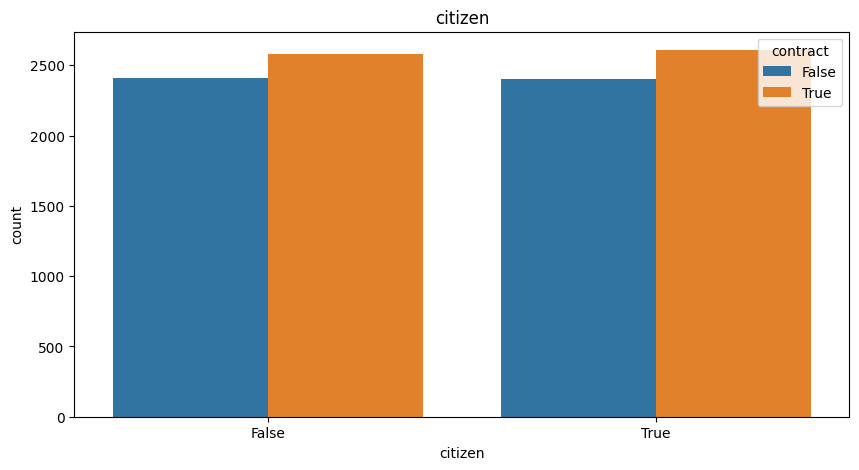

-------------------------------------------------------
Column:  yearsOfEducation
	Value:  1
	- Accepted:  11 -> 40.741 %
	- Denied:  16 -> 59.25899999999999 %

	Value:  2
	- Accepted:  23 -> 58.974000000000004 %
	- Denied:  16 -> 41.026 %

	Value:  3
	- Accepted:  64 -> 59.25899999999999 %
	- Denied:  44 -> 40.741 %

	Value:  4
	- Accepted:  116 -> 51.327 %
	- Denied:  110 -> 48.673 %

	Value:  5
	- Accepted:  182 -> 45.844 %
	- Denied:  215 -> 54.156000000000006 %

	Value:  6
	- Accepted:  342 -> 52.373999999999995 %
	- Denied:  311 -> 47.626000000000005 %

	Value:  7
	- Accepted:  485 -> 54.069 %
	- Denied:  412 -> 45.931 %

	Value:  8
	- Accepted:  621 -> 51.449999999999996 %
	- Denied:  586 -> 48.55 %

	Value:  9
	- Accepted:  734 -> 52.73 %
	- Denied:  658 -> 47.27 %

	Value:  10
	- Accepted:  721 -> 51.871 %
	- Denied:  669 -> 48.129 %

	Value:  11
	- Accepted:  650 -> 51.834 %
	- Denied:  604 -> 48.166 %

	Value:  12
	- Accepted:  507 -> 52.647999999999996 %
	- Denied:  456 -> 

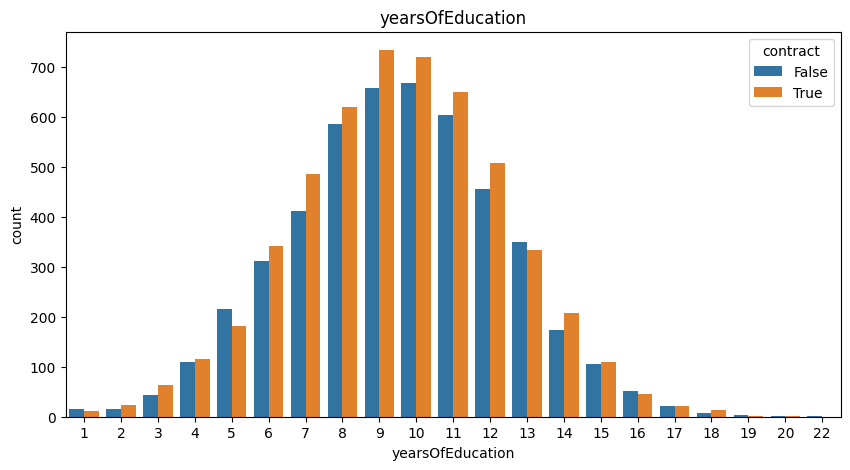

In [75]:
print_acceptance_denial_counts(flat_high)